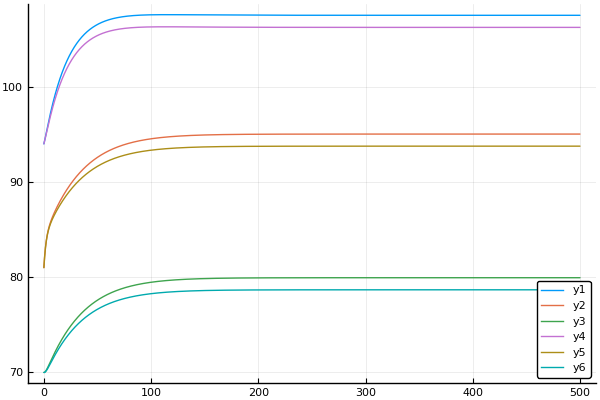

In [2]:
# ODE with various plots
#    for co-current and counter-current heat exchanger of Model 1
#Filename:Model1ODE-various-plots.ipynb
#Author:Madhusudhan Pandey, USN, EPE
#Date: March 20, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

using NLsolve
using DifferentialEquations
using Plots
pyplot();# pyplot attributes on backend
using LaTeXStrings;
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
# inputs (need to specify first than parameters as Qdfs is input dependent and considered as parameters)
Twc = 3.8
Ifd = 1055.
It = 5360.
QdFes = 212.
Wdf = 528.
mdw = 53.9
mda = 49.2
u = [Twc, Ifd, It, QdFes, Wdf, mdw, mda]
#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
Up=0.88 # "Product of overall heat transfer and perimeter"
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 
#
Rr = 0.16e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 3.5e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
#
aCu = 2.559380892459937
bCu = 0.0011982506064166993
aFe = 0.19724545575725203
bFe = 0.00676358006431966
aa = 3.2822556593357177
ba = 0.0006721070788120142
aw = 3.6394816337401976
bw = 0.0012723320470041624
alphaCu = 0.00404
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
Qdfs = 0.8*Wdf
#tuples of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
    MFe,Ma,Mw,Qdfs];
Tr0, Ts0, TFe0 = 94., 81., 70.
# Finding initial values for Tac, Tad, Tah
function f!(F, x)
    Tac0, Tad0, Tah0 = x[1], x[2], x[3]
    F[1] = mda*chpa*(Tac0-Tad0)+UAr2d*(Tr0-Tad0)+Qdfs
    F[2] = mda*chpa*(Tad0-Tah0)+UAFe2a*(TFe0-Tah0)
    #length span of heat exchanger
    xspan=(0.0,50.0)
    function heat_exchanger!(dT,T,par,t)
        #Ta=T[1]; Tw=T[2]
        dT[1]=Up/(chpa*mda)*(T[2]-T[1])
        dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
    end
    #initialGuess=[Tah,Twh]
    initial_guess=[Ta_o,Twc]
    function bc!(residual,T,par,t)
        residual[1]=T[1][1]-Tah0
        residual[2]=T[end][2]-Twc
    end
    bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
    sol=solve(bvp, Shooting(Vern7()))
    a,b=sol(50) #solves for Tac,Twc
    c,d=sol(0) #solves for Tah,Twh
    #One equation from BVP
    F[3] = Tac0 - a
end
Tac0, Tad0, Tah0 = nlsolve(f!,[Ta_o;Ta_o;Ta_o]).zero
# Tac0, Tad0 and Tah0 found
#Simulation step
dt = 10 # simulation step is high because our system response changes in minutes
initial_value_temp = [Tr0, Ts0, TFe0, Tac0, Tad0, Tah0]
# saving for counter current model for later use
initial_value_temp_for_counter_current = initial_value_temp
t_sim=range(0,stop=500*60,step=dt)
T_rotor = zeros(0)
T_stator = zeros(0)
T_iron = zeros(0)
T_air_cold = zeros(0)
T_air_delta = zeros(0)
T_air_hot = zeros(0)
#
append!(T_rotor,Tr0)
append!(T_stator,Ts0)
append!(T_iron,TFe0)
append!(T_air_cold,Tac0)
append!(T_air_delta,Tad0)
append!(T_air_hot,Tah0)
#append!(T_air,Tac0);append!(T_water,Tr0);
for i = 1:(length(t_sim)-1)
    function f!(F, x)
        # Unpacking Parameters
        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
        MFe,Ma,Mw = par
        # Unpacking inputs
        Twc, Ifd, It, QdFes, Wdf, mdw, mda = u
        # Initial values unknowns
        Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
        # Unpacking unknowns
        Tr = x[1]
        Ts = x[2]
        TFe = x[3]
        Tac = x[4]
        Tad = x[5]
        Tah = x[6]
        #using RK4 solver
        #finding RK slopes for rotor diff eq
        function Trotor(initial_value_temp)
            Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
            return dt*(1.1*Rr*Ifd^2-UAr2d*(Tr0-Tad0))/(mr*chpCu)
        end
        kr1=Trotor(initial_value_temp)
        kr2=Trotor(@. initial_value_temp+kr1)
        kr3=Trotor(@. initial_value_temp+kr2)
        kr4=Trotor(@. initial_value_temp+kr3)
        
        #finding RK slopes for stator diff eq
        function Tstator(initial_value_temp)
            Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
            return dt*(3*Rs*It^2-UAs2Fe*(Ts0-TFe0))/(ms*chpCu)
        end
        ks1=Tstator(initial_value_temp)
        ks2=Tstator(@. initial_value_temp+ks1)
        ks3=Tstator(@. initial_value_temp+ks2)
        ks4=Tstator(@. initial_value_temp+ks3)
        
        #finding RK slopes for iron diff eq
        function Tiron(initial_value_temp)
            Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
            return dt*(UAs2Fe*(Ts0-TFe0)-UAFe2a*(TFe0-Tah0)+QdFes)/(mFe*chpFe)
        end
        kFe1=Tiron(initial_value_temp)
        kFe2=Tiron(@. initial_value_temp+kFe1)
        kFe3=Tiron(@. initial_value_temp+kFe2)
        kFe4=Tiron(@. initial_value_temp+kFe3)
        
        F[1] = Tr - Tr0 - (kr1+2*(kr2+kr3)+kr4)/6
        F[2] = Ts - Ts0 - (ks1+2*(ks2+ks3)+ks4)/6
        F[3] = TFe - TFe0 - (kFe1+2*(kFe2+kFe3)+kFe4)/6
        F[4] = mda*chpa*(Tac0-Tad)+UAr2d*(Tr0-Tad0)+Qdfs
        F[5] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe0-Tah0)
        #length span of heat exchanger
        xspan=(0.0,50.0)
        function heat_exchanger!(dT,T,par,t)
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #Ta=T[1]; Tw=T[2]
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=-Up/(chpw*mdw)*(T[2]-T[1])
        end

        ##initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc]
        function bc!(residual,T,par,t)
            residual[1]=T[1][1]-Tah0#Tah#Tah
            residual[2]=T[1][2]-Twc#Twc
        end

        bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        
        a,b=sol(50) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        #One equation from BVP
        F[6] = Tac - a
    end
    initial_value_temp=nlsolve(f!, initial_value_temp).zero
    append!(T_rotor,initial_value_temp[1])
    append!(T_stator,initial_value_temp[2])
    append!(T_iron,initial_value_temp[3])
    append!(T_air_cold,initial_value_temp[4])
    append!(T_air_delta,initial_value_temp[5])
    append!(T_air_hot,initial_value_temp[6])
end

# Storing in some good names for later use
Tr_ODE_co_current_model1,Ts_ODE_co_current_model1,
TFe_ODE_co_current_model1,Tac_ODE_co_current_model1,
Tad_ODE_co_current_model1,
Tah_ODE_co_current_model1,t_ODE_co_current_model1 = T_rotor,T_stator,T_iron,T_air_cold,T_air_delta,T_air_hot, t_sim

# For counter-current ODE Model1
initial_value_temp=initial_value_temp_for_counter_current

T_rotor = zeros(0)
T_stator = zeros(0)
T_iron = zeros(0)
T_air_cold = zeros(0)
T_air_delta = zeros(0)
T_air_hot = zeros(0)
#
append!(T_rotor,Tr0)
append!(T_stator,Ts0)
append!(T_iron,TFe0)
append!(T_air_cold,Tac0)
append!(T_air_delta,Tad0)
append!(T_air_hot,Tah0)
#append!(T_air,Tac0);append!(T_water,Tr0);
for i = 1:(length(t_sim)-1)
    function f!(F, x)
        # Unpacking Parameters
        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
        MFe,Ma,Mw = par
        # Unpacking inputs
        Twc, Ifd, It, QdFes, Wdf, mdw, mda = u
        # Initial values unknowns
        Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
        # Unpacking unknowns
        Tr = x[1]
        Ts = x[2]
        TFe = x[3]
        Tac = x[4]
        Tad = x[5]
        Tah = x[6]
        #using RK4 solver
        #finding RK slopes for rotor diff eq
        function Trotor(initial_value_temp)
            Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
            return dt*(1.1*Rr*Ifd^2-UAr2d*(Tr0-Tad0))/(mr*chpCu)
        end
        kr1=Trotor(initial_value_temp)
        kr2=Trotor(@. initial_value_temp+kr1)
        kr3=Trotor(@. initial_value_temp+kr2)
        kr4=Trotor(@. initial_value_temp+kr3)
        
        #finding RK slopes for stator diff eq
        function Tstator(initial_value_temp)
            Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
            return dt*(3*Rs*It^2-UAs2Fe*(Ts0-TFe0))/(ms*chpCu)
        end
        ks1=Tstator(initial_value_temp)
        ks2=Tstator(@. initial_value_temp+ks1)
        ks3=Tstator(@. initial_value_temp+ks2)
        ks4=Tstator(@. initial_value_temp+ks3)
        
        #finding RK slopes for iron diff eq
        function Tiron(initial_value_temp)
            Tr0, Ts0, TFe0, Tac0, Tad0, Tah0 = initial_value_temp
            return dt*(UAs2Fe*(Ts0-TFe0)-UAFe2a*(TFe0-Tah0)+QdFes)/(mFe*chpFe)
        end
        kFe1=Tiron(initial_value_temp)
        kFe2=Tiron(@. initial_value_temp+kFe1)
        kFe3=Tiron(@. initial_value_temp+kFe2)
        kFe4=Tiron(@. initial_value_temp+kFe3)
        
        F[1] = Tr - Tr0 - (kr1+2*(kr2+kr3)+kr4)/6
        F[2] = Ts - Ts0 - (ks1+2*(ks2+ks3)+ks4)/6
        F[3] = TFe - TFe0 - (kFe1+2*(kFe2+kFe3)+kFe4)/6
        F[4] = mda*chpa*(Tac0-Tad)+UAr2d*(Tr0-Tad0)+Qdfs
        F[5] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe0-Tah0)
        #length span of heat exchanger
        xspan=(0.0,50.0)
        function heat_exchanger!(dT,T,par,t)
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #Ta=T[1]; Tw=T[2]
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        end

        ##initialGuess=[Tah,Twh]
        initial_guess=[42.27,8.36]
        function bc!(residual,T,par,t)
            residual[1]=T[1][1]-Tah0#Tah#Tah
            residual[2]=T[end][2]-Twc#Twc
        end

        bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        
        a,b=sol(50) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        #One equation from BVP
        F[6] = Tac - a
    end
    initial_value_temp=nlsolve(f!, initial_value_temp).zero
    append!(T_rotor,initial_value_temp[1])
    append!(T_stator,initial_value_temp[2])
    append!(T_iron,initial_value_temp[3])
    append!(T_air_cold,initial_value_temp[4])
    append!(T_air_delta,initial_value_temp[5])
    append!(T_air_hot,initial_value_temp[6])
end

# Storing in some good names for later use
Tr_ODE_counter_current_model1,Ts_ODE_counter_current_model1,
TFe_ODE_counter_current_model1,Tac_ODE_counter_current_model1,
Tad_ODE_counter_current_model1,Tah_ODE_counter_current_model1,
t_ODE_counter_current_model1 = T_rotor,T_stator,T_iron,T_air_cold,T_air_delta,T_air_hot, t_sim


# Storing in JLD type for later use in various comparision plots
# Storing in JLD format
# See. https://github.com/JuliaIO/JLD.jl

using JLD
ODE_co_and_counter_model1 = [Tr_ODE_co_current_model1,Ts_ODE_co_current_model1,
TFe_ODE_co_current_model1,Tac_ODE_co_current_model1,Tad_ODE_co_current_model1,
Tah_ODE_co_current_model1,t_ODE_co_current_model1,Tr_ODE_counter_current_model1,
Ts_ODE_counter_current_model1,TFe_ODE_counter_current_model1,
Tac_ODE_counter_current_model1,Tad_ODE_counter_current_model1,
Tah_ODE_counter_current_model1,t_ODE_co_current_model1]
# saved as "DAE_co_and_counter_model1.jld" in same directory
save("ODE_co_and_counter_model1.jld", "ODE_co_and_counter_model1", ODE_co_and_counter_model1)

plot(t_ODE_co_current_model1/60,Tr_ODE_co_current_model1)
plot!(t_ODE_co_current_model1/60,Ts_ODE_co_current_model1)
plot!(t_ODE_co_current_model1/60,TFe_ODE_co_current_model1)
plot!(t_ODE_counter_current_model1/60,Tr_ODE_counter_current_model1)
plot!(t_ODE_counter_current_model1/60,Ts_ODE_counter_current_model1)
plot!(t_ODE_counter_current_model1/60,TFe_ODE_counter_current_model1)
